# Exercise 4

## Import packages

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [21]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, item in enumerate(train_loader):
        img, true_label = item
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(img)
        
        # TODO: compute negative log likelihood loss
        loss_function = nn.NLLLoss()
        loss = loss_function(output, true_label)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print(loss)

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [22]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [23]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
    
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Linear(100, 60),
            nn.Sigmoid(),
            nn.Linear(60, 30),
            nn.Sigmoid(),
            nn.Linear(30, 10)
            )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        output = self.linear_sigmoid_stack(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.softmax(output)
        
        return output

In [24]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
    
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
            )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        output = self.linear_relu_stack(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.softmax(output)
        
        return output

In [25]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
    
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.BatchNorm1d(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.BatchNorm1d(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 10)
            )

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        output = self.linear_relu_stack(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.softmax(output)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [26]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(28*28,26*26, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(26*26,12*12, kernel_size=3),
            nn.ReLU()
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )
        

    def forward(self, x):
        # TODO: run convolutional layers
        output = self.conv_relu_stack(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        output.Flatten()
        
        # TODO: run fully connected layers
        output = self.linear_relu_stack(output)
        
        # TODO: compute log softmax over the output
        output = nn.LogSoftmax(output)
        
        return output

In [27]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(28*28,26*26, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm3d(),
            nn.Conv2d(26*26,12*12, kernel_size=3),
            nn.ReLU()
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.BatchNorm1d(),
            nn.Linear(128, 10),
            nn.ReLU()
        )

    def forward(self, x):

        output = self.conv_relu_stack(x)
        
        output.Flatten()
        
        output = self.linear_relu_stack(output)
        
        output = nn.LogSoftmax(output)

        return output

In [28]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(28*28,26*26, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.ReLU()
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )
        
    def forward(self, x):
        output = self.conv_relu_stack(x)
        
        output.Flatten()
        
        output = self.linear_relu_stack(output)
        
        output = nn.LogSoftmax(output)

        return output

/var/folders/kf/2r_v79wn3v1g_w1ngzsh6vlm0000gn/T/ipykernel_70988/3714858893.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


tensor(-0.1019, grad_fn=<NllLossBackward0>)
tensor(-0.2852, grad_fn=<NllLossBackward0>)
tensor(-0.6043, grad_fn=<NllLossBackward0>)
tensor(-0.7183, grad_fn=<NllLossBackward0>)
tensor(-0.6594, grad_fn=<NllLossBackward0>)
tensor(-0.7644, grad_fn=<NllLossBackward0>)
tensor(-0.7600, grad_fn=<NllLossBackward0>)
tensor(-0.7789, grad_fn=<NllLossBackward0>)
tensor(-0.7701, grad_fn=<NllLossBackward0>)
tensor(-0.8053, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.7214, Accuracy: 7240/10000 (72.40%)



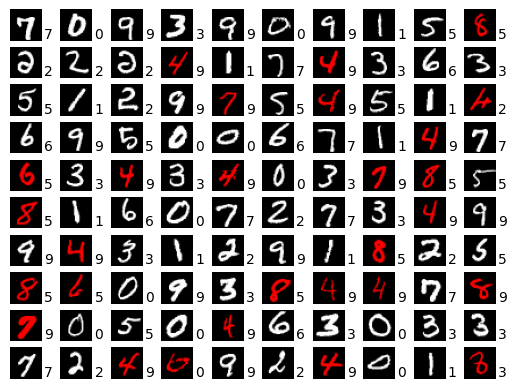

tensor(-0.8131, grad_fn=<NllLossBackward0>)
tensor(-0.6563, grad_fn=<NllLossBackward0>)
tensor(-0.8015, grad_fn=<NllLossBackward0>)
tensor(-0.8424, grad_fn=<NllLossBackward0>)
tensor(-0.7431, grad_fn=<NllLossBackward0>)
tensor(-0.9099, grad_fn=<NllLossBackward0>)
tensor(-0.8125, grad_fn=<NllLossBackward0>)
tensor(-0.9198, grad_fn=<NllLossBackward0>)
tensor(-0.9175, grad_fn=<NllLossBackward0>)
tensor(-0.8434, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8551, Accuracy: 8560/10000 (85.60%)



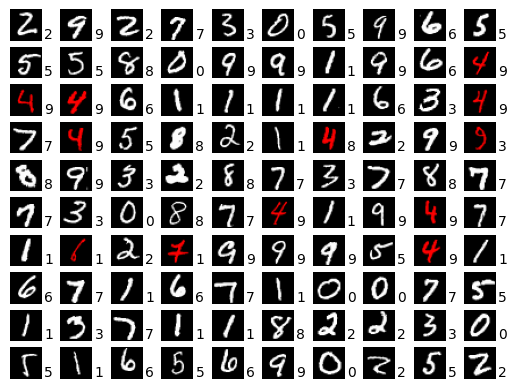

tensor(-0.8132, grad_fn=<NllLossBackward0>)
tensor(-0.8471, grad_fn=<NllLossBackward0>)
tensor(-0.9414, grad_fn=<NllLossBackward0>)
tensor(-0.8414, grad_fn=<NllLossBackward0>)
tensor(-0.8768, grad_fn=<NllLossBackward0>)
tensor(-0.9686, grad_fn=<NllLossBackward0>)
tensor(-0.8198, grad_fn=<NllLossBackward0>)
tensor(-0.8062, grad_fn=<NllLossBackward0>)
tensor(-0.9061, grad_fn=<NllLossBackward0>)
tensor(-0.8450, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8627, Accuracy: 8631/10000 (86.31%)



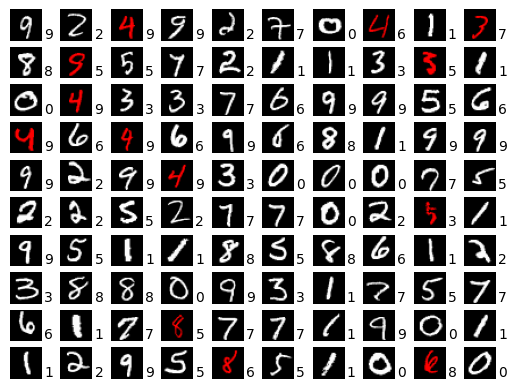

tensor(-0.8845, grad_fn=<NllLossBackward0>)
tensor(-0.8868, grad_fn=<NllLossBackward0>)
tensor(-0.8352, grad_fn=<NllLossBackward0>)
tensor(-0.8278, grad_fn=<NllLossBackward0>)
tensor(-0.9328, grad_fn=<NllLossBackward0>)
tensor(-0.8589, grad_fn=<NllLossBackward0>)
tensor(-0.8605, grad_fn=<NllLossBackward0>)
tensor(-0.8906, grad_fn=<NllLossBackward0>)
tensor(-0.9375, grad_fn=<NllLossBackward0>)
tensor(-0.9056, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8735, Accuracy: 8743/10000 (87.43%)



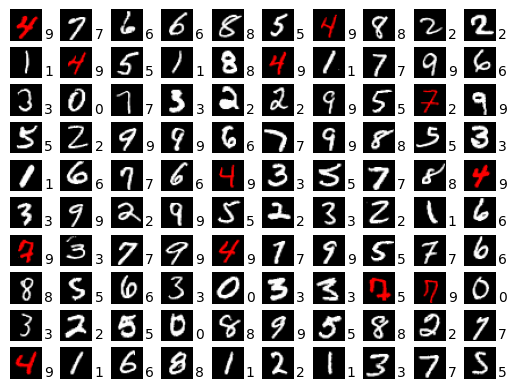

tensor(-0.9478, grad_fn=<NllLossBackward0>)
tensor(-0.8551, grad_fn=<NllLossBackward0>)
tensor(-0.8434, grad_fn=<NllLossBackward0>)
tensor(-0.8737, grad_fn=<NllLossBackward0>)
tensor(-0.9035, grad_fn=<NllLossBackward0>)
tensor(-0.9219, grad_fn=<NllLossBackward0>)
tensor(-0.8727, grad_fn=<NllLossBackward0>)
tensor(-0.8578, grad_fn=<NllLossBackward0>)
tensor(-0.8517, grad_fn=<NllLossBackward0>)
tensor(-0.9424, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8716, Accuracy: 8721/10000 (87.21%)



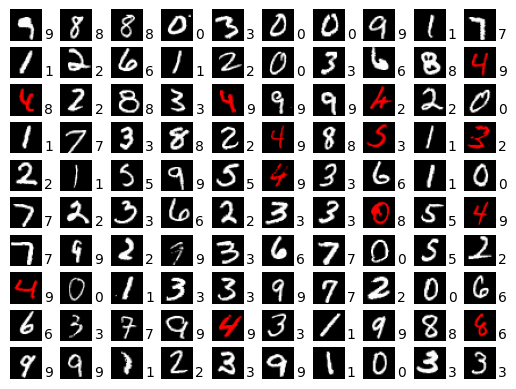

tensor(-0.9082, grad_fn=<NllLossBackward0>)
tensor(-0.8969, grad_fn=<NllLossBackward0>)
tensor(-0.9071, grad_fn=<NllLossBackward0>)
tensor(-0.8909, grad_fn=<NllLossBackward0>)
tensor(-0.8810, grad_fn=<NllLossBackward0>)
tensor(-0.9680, grad_fn=<NllLossBackward0>)
tensor(-0.8313, grad_fn=<NllLossBackward0>)
tensor(-0.8594, grad_fn=<NllLossBackward0>)
tensor(-0.9499, grad_fn=<NllLossBackward0>)
tensor(-0.8906, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8762, Accuracy: 8768/10000 (87.68%)



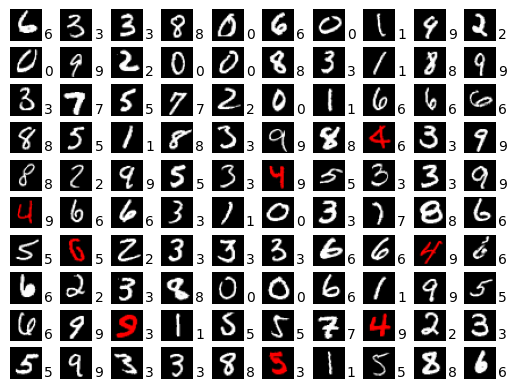

tensor(-0.8437, grad_fn=<NllLossBackward0>)
tensor(-0.8281, grad_fn=<NllLossBackward0>)
tensor(-0.8748, grad_fn=<NllLossBackward0>)
tensor(-0.8659, grad_fn=<NllLossBackward0>)
tensor(-0.8428, grad_fn=<NllLossBackward0>)
tensor(-0.8793, grad_fn=<NllLossBackward0>)
tensor(-0.9218, grad_fn=<NllLossBackward0>)
tensor(-0.9059, grad_fn=<NllLossBackward0>)
tensor(-0.9102, grad_fn=<NllLossBackward0>)
tensor(-0.8804, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8764, Accuracy: 8767/10000 (87.67%)



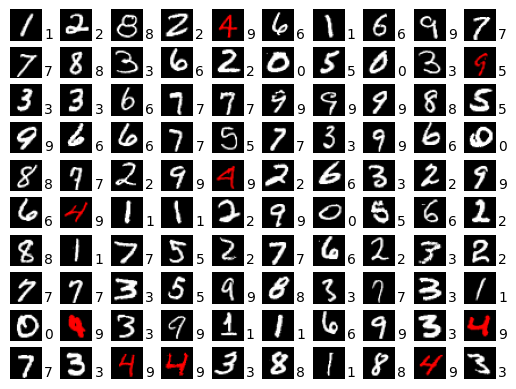

tensor(-0.8750, grad_fn=<NllLossBackward0>)
tensor(-0.8740, grad_fn=<NllLossBackward0>)
tensor(-0.8260, grad_fn=<NllLossBackward0>)
tensor(-0.8798, grad_fn=<NllLossBackward0>)
tensor(-0.8426, grad_fn=<NllLossBackward0>)
tensor(-0.9060, grad_fn=<NllLossBackward0>)
tensor(-0.8417, grad_fn=<NllLossBackward0>)
tensor(-0.8750, grad_fn=<NllLossBackward0>)
tensor(-0.9100, grad_fn=<NllLossBackward0>)
tensor(-0.8906, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8766, Accuracy: 8766/10000 (87.66%)



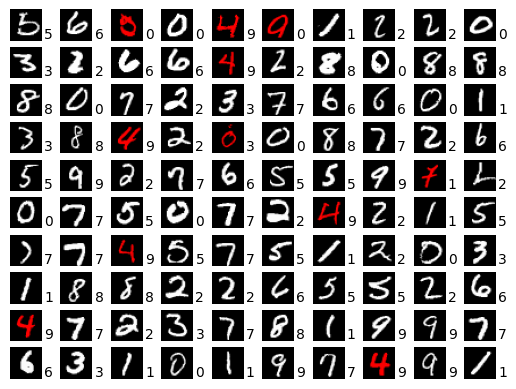

tensor(-0.9055, grad_fn=<NllLossBackward0>)
tensor(-0.9219, grad_fn=<NllLossBackward0>)
tensor(-0.9369, grad_fn=<NllLossBackward0>)
tensor(-0.9055, grad_fn=<NllLossBackward0>)
tensor(-0.8905, grad_fn=<NllLossBackward0>)
tensor(-0.8281, grad_fn=<NllLossBackward0>)
tensor(-0.9062, grad_fn=<NllLossBackward0>)
tensor(-0.8591, grad_fn=<NllLossBackward0>)
tensor(-0.8750, grad_fn=<NllLossBackward0>)
tensor(-0.9034, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8772, Accuracy: 8778/10000 (87.78%)



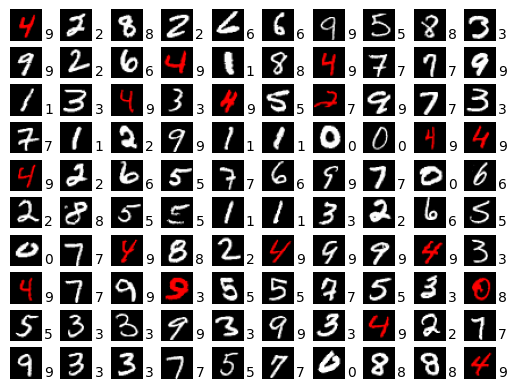

tensor(-0.8726, grad_fn=<NllLossBackward0>)
tensor(-0.8592, grad_fn=<NllLossBackward0>)
tensor(-0.8274, grad_fn=<NllLossBackward0>)
tensor(-0.8437, grad_fn=<NllLossBackward0>)
tensor(-0.8588, grad_fn=<NllLossBackward0>)
tensor(-0.9058, grad_fn=<NllLossBackward0>)
tensor(-0.9375, grad_fn=<NllLossBackward0>)
tensor(-0.9063, grad_fn=<NllLossBackward0>)
tensor(-0.8593, grad_fn=<NllLossBackward0>)
tensor(-0.8906, grad_fn=<NllLossBackward0>)

Test set: Average loss: -0.8774, Accuracy: 8776/10000 (87.76%)



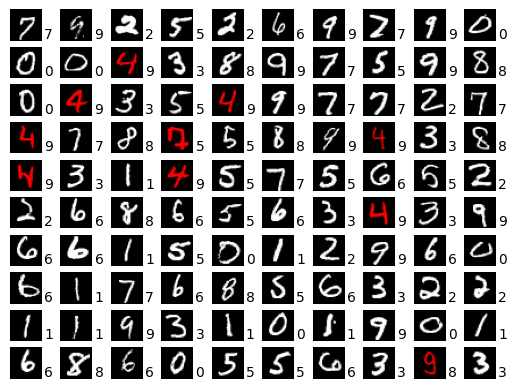

In [29]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")